# Installing Library

In [ ]:
!pip install colour-science
!pip install colormath

## Importing Library

In [1]:
import os,argparse
import numpy as np
from PIL import Image
import torch
import torch.nn as nn

import torch.nn.functional as F
import torchvision.transforms as tfs 
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# PDR-Net M


In [2]:
def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size,padding=(kernel_size//2), bias=bias)
    

# --- Build dense --- #
class MakeDense(nn.Module):
    def __init__(self, in_channels, growth_rate, kernel_size=3):
        super(MakeDense, self).__init__()
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=kernel_size, padding=(kernel_size-1)//2)

    def forward(self, x):
        out = F.relu(self.conv(x))
        out = torch.cat((x, out), 1)
        return out

# --- Build the Residual Dense Block --- #
class RDB(nn.Module):
    def __init__(self, in_channels, num_dense_layer, growth_rate):
        """
        :param in_channels: input channel size
        :param num_dense_layer: the number of RDB layers
        :param growth_rate: growth_rate
        """
        super(RDB, self).__init__()
        _in_channels = in_channels
        modules = []
        for i in range(num_dense_layer):
            modules.append(MakeDense(_in_channels, growth_rate))
            _in_channels += growth_rate
        self.residual_dense_layers = nn.Sequential(*modules)
        self.conv_1x1 = nn.Conv2d(_in_channels, in_channels, kernel_size=1, padding=0)

    def forward(self, x):
        out = self.residual_dense_layers(x)
        out = self.conv_1x1(out)
        out = out + x
        return out

# Build PA Layer
class PALayer(nn.Module):
  def __init__(self, channel):
    super(PALayer, self).__init__()
    self.pa = nn.Sequential(
        nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(channel // 8, 1, 1, padding=0, bias=True),
        nn.Sigmoid()
        )
  def forward(self, x):
    y = self.pa(x)
    return x * y

# Build CA Layer
class CALayer(nn.Module):
  def __init__(self, channel):
    super(CALayer, self).__init__()
    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.ca = nn.Sequential(
        nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(channel // 8, channel, 1, padding=0, bias=True),
        nn.Sigmoid()
        )
  def forward(self, x):
    y = self.avg_pool(x)
    y = self.ca(y)
    return x * y

# Build Preprocessing Module
class PreprocessingModule(nn.Module):
  def __init__(self, in_channel, out_channel, kernel_size):
    super(PreprocessingModule, self).__init__() 
    if kernel_size ==3:
      self.conv1 =  nn.Conv2d(in_channel, out_channel, kernel_size,padding=(kernel_size//2), bias=True)
    elif kernel_size == 5:
      self.conv1 =  nn.Conv2d(in_channel, out_channel, kernel_size,padding=(kernel_size//2), bias=True)
    else:
      self.conv1 =  nn.Conv2d(in_channel, out_channel, kernel_size,padding=(kernel_size//2), bias=True)
    self.rdb =  RDB(in_channels= out_channel, num_dense_layer=4, growth_rate=out_channel )
  
  def forward(self, x):
    x = self.conv1(x)
    out = self.rdb(x)
    return out

# Build post-processing module
class PostprocessingModule(nn.Module):
  def __init__(self, channel, kernel_size):
    super(PostprocessingModule, self).__init__() 
    self.conv1 =  nn.Conv2d(channel, 3, kernel_size,padding=(kernel_size//2), bias=True)
    self.rdb =  RDB(in_channels= channel, num_dense_layer=4, growth_rate=64)
  
  def forward(self, x):
    x = self.rdb(x)
    out = self.conv1(x)
    return out

class HazeRemovalSubNetwork(nn.Module):
  def __init__(self, channel, kernel_size, dilation=1):
    super(HazeRemovalSubNetwork, self).__init__()
    if dilation == 1:
      self.conv_64 = nn.Conv2d(in_channels = channel,
                           out_channels = channel, 
                           kernel_size=kernel_size,
                           padding=(kernel_size//2),
                           bias=True)
    else:
      self.conv_64 = nn.Conv2d(in_channels = channel,
                           out_channels = channel, 
                           kernel_size=kernel_size,
                           dilation = dilation,
                           padding=dilation,
                           bias=True)
    self.palayer = PALayer(channel = channel)
    self.calayer = CALayer(channel = channel)
  def forward(self, x):
    #core line
    core = F.relu(self.conv_64(x))
    core1 = F.relu(self.conv_64(core + x))
    core2 = F.relu(self.conv_64(core1 + core + x))
    core3 = F.relu(self.conv_64(core2 + core1 + core + x))
    sum1 = x + core + core1 + core2 + core3

    core4 = F.relu(self.conv_64(sum1))
    core5 = F.relu(self.conv_64(core4 + sum1))
    core6 = F.relu(self.conv_64(core5 + core4 + sum1))
    core7 = F.relu(self.conv_64(core6 + core5 + core4 + sum1))
    sum2 = sum1 + core4 + core5 + core6 + core7

    core8 = F.relu(self.conv_64(sum2))
    #skip connection line
    skip = F.relu(self.conv_64(x))
    core8 = self.calayer(core8)
    core8 = self.palayer(core8)
    sum3 = core8 + skip

    out = self.conv_64(sum3)
    return out

class RefinementSubNetwork(nn.Module):
  def __init__(self,  channel, kernel_size, dilation=1):
    super(RefinementSubNetwork, self).__init__()
    if dilation == 1:
      self.conv_32_32 = nn.Conv2d(in_channels = channel,
                           out_channels = channel, 
                           kernel_size=kernel_size,
                           padding=(kernel_size//2),
                           bias=True)
    else:
      self.conv_32_32 = nn.Conv2d(in_channels = channel,
                           out_channels = channel, 
                           kernel_size=kernel_size,
                           dilation = dilation,
                           padding=dilation,
                           bias=True)
    self.palayer = PALayer(channel = channel)
    self.calayer = CALayer(channel = channel)
  def forward(self, x):
    #core line
    core = F.relu(self.conv_32_32(x))
    core1 = F.relu(self.conv_32_32(core))
    core2 = F.relu(self.conv_32_32(core1))
    core3 = F.relu(self.conv_32_32(core2))
    sum1 = x + core + core1 + core2 + core3

    core4 = F.relu(self.conv_32_32(sum1))
    core5 = F.relu(self.conv_32_32(core4))
    core6 = F.relu(self.conv_32_32(core5))
    core7 = F.relu(self.conv_32_32(core6))
    sum2 = sum1 + core4 + core5 + core6 + core7

    core8 = F.relu(self.conv_32_32(sum2))
    #skip connection line
    skip = F.relu(self.conv_32_32(x))
    # core8 = self.calayer(core8)
    # core8 = self.palayer(core8)
    sum3 = core8 + skip

    out = self.conv_32_32(sum3)
    return out

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.preprocessing_haze_sub1 = PreprocessingModule(in_channel=3, out_channel=64, kernel_size=3)
    self.hazeremovalsubnetwork_sub1 = HazeRemovalSubNetwork(channel=64, kernel_size=3)
    self.hazeremovalsubnetwork_sub2 = HazeRemovalSubNetwork(channel=64, kernel_size=3, dilation = 2)
    self.hazeremovalsubnetwork_sub3 = HazeRemovalSubNetwork(channel=64, kernel_size=3, dilation = 4)
    self.hazeremovalsubnetwork_sub4 = HazeRemovalSubNetwork(channel=64, kernel_size=3, dilation = 8)
    
    self.palayer_haze_sub1 = PALayer(channel = 64)
    self.calayer_haze_sub1 = CALayer(channel = 64)
    
    self.preprocessing_refine_sub1 = PreprocessingModule(in_channel=3, out_channel=64, kernel_size=3)
    self.palayer_refine_sub1 = PALayer(channel = 64)
    self.calayer_refine_sub1 = CALayer(channel = 64)
    
    self.refinementsubnetwork_sub2 = RefinementSubNetwork(channel=64, kernel_size=3, dilation=2)
    self.refinementsubnetwork_sub3 = RefinementSubNetwork(channel=64, kernel_size=3, dilation=4)
    self.refinementsubnetwork_sub4 = RefinementSubNetwork(channel=64, kernel_size=3, dilation=8)
    
    self.postprocessing_refine_sub1 = PostprocessingModule(channel=64, kernel_size=3)
    
    # self.postprocessing_last = PostprocessingModule(channel=3, kernel_size=3)
    self.postprocessing_haze_last = PostprocessingModule(channel=64, kernel_size=3)
    self.conv_64_64 = default_conv(64,64,3)
    self.conv_3_64 = default_conv(3,64,3)
    
  def forward(self, x):
    

    #hazesub1
    preprocess_haze_sub1 = self.preprocessing_haze_sub1(x)


    hazeremoval_sub1_4 = self.hazeremovalsubnetwork_sub1(preprocess_haze_sub1)
    calayer_haze_sub1_5 = self.calayer_haze_sub1(hazeremoval_sub1_4)
    palayer_haze_sub1_6 = self.palayer_haze_sub1(calayer_haze_sub1_5)
    
    hazeremoval_sub2_4 = self.hazeremovalsubnetwork_sub2(preprocess_haze_sub1)
    calayer_haze_sub2_5 = self.calayer_haze_sub1(hazeremoval_sub2_4)
    palayer_haze_sub2_6 = self.palayer_haze_sub1(calayer_haze_sub2_5)

    hazeremoval_sub3_4 = self.hazeremovalsubnetwork_sub3(preprocess_haze_sub1)
    calayer_haze_sub3_5 = self.calayer_haze_sub1(hazeremoval_sub3_4)
    palayer_haze_sub3_6 = self.palayer_haze_sub1(calayer_haze_sub3_5)

    hazeremoval_sub4_4 = self.hazeremovalsubnetwork_sub4(preprocess_haze_sub1)
    calayer_haze_sub4_5 = self.calayer_haze_sub1(hazeremoval_sub4_4)
    palayer_haze_sub4_6 = self.palayer_haze_sub1(calayer_haze_sub4_5)


    concat_haze_refine_1 = palayer_haze_sub1_6 + palayer_haze_sub2_6 + palayer_haze_sub3_6 + palayer_haze_sub4_6 
   
    calayer_haze_sub = self.calayer_haze_sub1(concat_haze_refine_1)
    palayer_haze_sub = self.palayer_haze_sub1(calayer_haze_sub)
    conv_haze_sub1 = self.conv_64_64(palayer_haze_sub)
    conv_haze_sub2 = self.conv_64_64(conv_haze_sub1)

    conv_pass_haze_sub1 = self.conv_3_64(x)


    concat1_haze_sub1 = conv_haze_sub2 + conv_pass_haze_sub1
  
    out = self.postprocessing_haze_last(concat1_haze_sub1)

    #refine
    preprocessing_refine_sub1 = self.preprocessing_refine_sub1(out)

    refine_sub5_4 = self.refinementsubnetwork_sub4(preprocessing_refine_sub1)
    calayer_refine_sub5_5 = self.calayer_refine_sub1(refine_sub5_4)
    palayer_refine_sub5_6 = self.palayer_refine_sub1(calayer_refine_sub5_5)

    refine_sub6_4 = self.refinementsubnetwork_sub2(preprocessing_refine_sub1)
    calayer_refine_sub6_5 = self.calayer_refine_sub1(refine_sub6_4)
    palayer_refine_sub6_6 = self.palayer_refine_sub1(calayer_refine_sub6_5)

    refine_sub7_4 = self.refinementsubnetwork_sub3(preprocessing_refine_sub1)
    calayer_refine_sub7_5 = self.calayer_refine_sub1(refine_sub7_4)
    palayer_refine_sub7_6 = self.palayer_refine_sub1(calayer_refine_sub7_5)
    
    concat_refine_sub_1 = palayer_refine_sub5_6 + palayer_refine_sub6_6 + palayer_refine_sub7_6

    calayer_refine_sub = self.calayer_refine_sub1(concat_refine_sub_1)
    palayer_refine_sub = self.palayer_refine_sub1(calayer_refine_sub)
    conv_refine_sub1 = self.conv_64_64(palayer_refine_sub)
    conv_refine_sub2 = self.conv_64_64(conv_refine_sub1)

    conv_pass_refine_sub1 = self.conv_3_64(out)
    concat1_haze_sub1 = conv_refine_sub2 + conv_pass_refine_sub1


    # refine_concat =postprocessing_sub1 + postprocessing_sub2 + postprocessing_sub3

    out = self.postprocessing_refine_sub1(concat1_haze_sub1)
    return out


In [3]:
abs=os.getcwd()+'/'
def tensorShow(tensors,titles=['haze']):
        fig=plt.figure()
        for tensor,tit,i in zip(tensors,titles,range(len(tensors))):
            img = make_grid(tensor)
            npimg = img.numpy()
            ax = fig.add_subplot(221+i)
            ax.imshow(np.transpose(npimg, (1, 2, 0)))
            ax.set_title(tit)
        plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
pre = '/content/drive/MyDrive/ProyekPengCit/DL/'

In [4]:
pre = 'DL/'

# Load Model 

In [5]:
model_dir=pre+'trained_models_best/ots_train_mod_pdr_net.pk'
device='cuda' if torch.cuda.is_available() else 'cpu'
ckp=torch.load(model_dir,map_location=device)

In [6]:
net = Net()
net=nn.DataParallel(net)

net.load_state_dict(ckp['model'], strict=False)
net.to(device)


DataParallel(
  (module): Net(
    (preprocessing_haze_sub1): PreprocessingModule(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (rdb): RDB(
        (residual_dense_layers): Sequential(
          (0): MakeDense(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): MakeDense(
            (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (2): MakeDense(
            (conv): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (3): MakeDense(
            (conv): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (conv_1x1): Conv2d(320, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (hazeremovalsubnetwork_sub1): HazeRemovalSubNetwork(
      (conv_64): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (palayer): PALayer(
        (pa): 

# Metric Evaluation

In [7]:
from math import exp
import time,math
from torch.autograd import Variable
from colormath.color_diff import delta_e_cie1976
import colour
import cv2

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)


def ssim(img1, img2, window_size=11, size_average=True):
    img1=torch.clamp(img1,min=0,max=1)
    img2=torch.clamp(img2,min=0,max=1)
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    return _ssim(img1, img2, window, window_size, channel, size_average)
def psnr(pred, gt):
    pred=pred.clamp(0,1).cpu().numpy()
    gt=gt.clamp(0,1).cpu().numpy()
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10( 1.0 / rmse)

def delta_e(pred, gt):
    image1_rgb = cv2.imread(pred)
    image2_rgb = cv2.imread(gt)

    image1_lab = cv2.cvtColor(image1_rgb.astype(np.float32) / 255, cv2.COLOR_RGB2Lab)
    image2_lab = cv2.cvtColor(image2_rgb.astype(np.float32) / 255, cv2.COLOR_RGB2Lab)

  
    delta_e_result = colour.delta_E_CIE2000(image1_lab, image2_lab)
    
    return np.mean(delta_e_result)

# Testing

In [12]:
testing_mode = 'with_gt' # change the value if you will test without gt
if testing_mode == 'with_gt':
    # testing_path = 'test_images_with_gt/hazy/'
    testing_path = pre+'test_images_with_gt/hazy/'
else:
    testing_path = 'test_images/'
print(testing_path)

DL/test_images_with_gt/hazy/


In [25]:
output_path = pre+'test_results/test_results_Mod_PDR_Net/'

04_outdoor_hazy.jpg


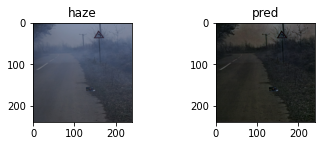

ssim : 0.6554131507873535 psnr : 13.43896946423798 runtime : 1.5769991874694824
08_outdoor_hazy.jpg


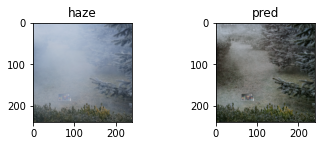

ssim : 0.8065224289894104 psnr : 19.602745693356564 runtime : 1.5210034847259521
14_outdoor_hazy.jpg


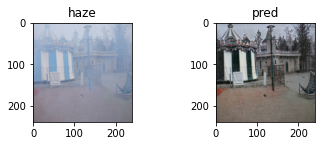

ssim : 0.8630300760269165 psnr : 18.414640219038247 runtime : 1.6700000762939453
20_outdoor_hazy.jpg


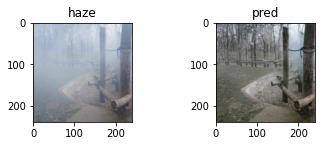

ssim : 0.8234785795211792 psnr : 17.35150514470434 runtime : 1.5329999923706055
21_outdoor_hazy.jpg


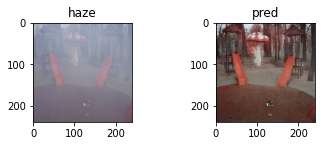

ssim : 0.883968710899353 psnr : 22.417597035559375 runtime : 1.7729990482330322
22_outdoor_hazy.jpg


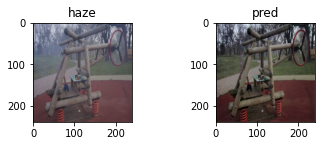

ssim : 0.9451869130134583 psnr : 26.227678554698528 runtime : 1.7409989833831787
23_outdoor_hazy.jpg


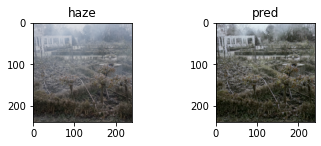

ssim : 0.9323331713676453 psnr : 23.618495996481368 runtime : 1.3649988174438477
41_outdoor_hazy.jpg


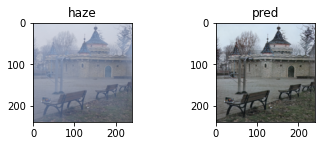

ssim : 0.9376341104507446 psnr : 24.151390615092538 runtime : 1.1720044612884521
45_outdoor_hazy.jpg


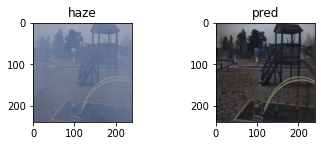

ssim : 0.8292368054389954 psnr : 19.337622767547433 runtime : 1.265998363494873
SSIM :  0.852978216277
PSNR :  20.5067383879


In [28]:
from tqdm.auto import tqdm
ssims = []
psnrs = []
times  = []
delta_e_array = []
for img in os.listdir(testing_path):
    print(img)
    start = time.time()
    haze = Image.open(testing_path+img).convert('RGB')
    if testing_mode == "with_gt":
        haze = tfs.Resize((240,240))(haze)
       
    haze1= tfs.Compose([
                        tfs.ToTensor(),
                        tfs.Normalize(mean=[0.64, 0.6, 0.58],std=[0.14,0.15, 0.152])])(haze)[None,::]
    haze_no=tfs.ToTensor()(haze)[None,::]
    with torch.no_grad():
        pred = net(haze1)
    ts=torch.squeeze(pred.clamp(0,1).cpu())
    tensorShow([haze_no,pred.clamp(0,1).cpu()],['haze','pred'])
    vutils.save_image(ts, output_path+img.split('.')[0]+'_FFA.jpg')
    torch.cuda.empty_cache()

    if testing_mode == "with_gt":
        split_name = img.split('_')
        img_gt = pre+'test_images_with_gt/GT/'+split_name[0]+"_outdoor_GT.jpg"

        targets = Image.open(img_gt).convert('RGB')
        targets =tfs.Resize((240,240))(targets)
        targets_new= tfs.Compose([
            tfs.ToTensor(),
            tfs.Normalize(mean=[0.64, 0.6, 0.58],std=[0.14,0.15, 0.152])
        ])(targets)[None,::]
        
        targets=tfs.ToTensor()(targets)[None,::]
        targets =targets.to(device="cpu")
        pred = pred.to(device="cpu")

        ssim1=ssim(pred, targets).item()
        psnr1=psnr(pred, targets)
        end = time.time()
        # delta_e1= delta_e(img_gt, output_path+img.split('.')[0]+'_FFA.jpg')

        print("ssim : "+str(ssim1) +" "+"psnr : "+str(psnr1) +" "+ "runtime : "+str(end-start))
        # print("delta e : "+ str(delta_e1))

        ssims.append(ssim1)
        psnrs.append(psnr1)
        times.append(end-start)
        # delta_e_array.append(delta_e1)

if testing_mode == "with_gt":
    print("SSIM : ", np.mean(ssims))  
    print("PSNR : ", np.mean(psnrs))  
    # print("DELTA E : ", np.mean(delta_e_array))  

In [46]:
print(f"{'No. '} {'ssim':9s}{'psnr':10s}{'time (s)':10s}")

for i, img in enumerate(os.listdir(testing_path)):
    print(f"{int(img[:2]):<4d} {ssims[i]:5f} {psnrs[i]:5f} {times[i]:5f}")

No.  ssim     psnr      time (s)  
4    0.655413 13.438969 1.576999
8    0.806522 19.602746 1.521003
14   0.863030 18.414640 1.670000
20   0.823479 17.351505 1.533000
21   0.883969 22.417597 1.772999
22   0.945187 26.227679 1.740999
23   0.932333 23.618496 1.364999
41   0.937634 24.151391 1.172004
45   0.829237 19.337623 1.265998


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.DataFrame(ssims, columns=("SSIM Result",)).describe()

,SSIM Result
count,9.000000
mean,0.852978
std,0.090590
min,0.655413
25%,0.823479
50%,0.863030
75%,0.932333
max,0.945187


In [26]:
pd.DataFrame(times, columns=("Runtime Results in Seconds",)).describe()

,Runtime Results in Seconds
count,9.000000
mean,1.565445
std,0.172800
min,1.227985
25%,1.496006
50%,1.571014
75%,1.648998
max,1.793002


In [14]:
testing_mode = '' # change the value if you will test without gt
if testing_mode == 'with_gt':
    # testing_path = 'test_images_with_gt/hazy/'
    testing_path = pre+'test_images_with_gt/hazy/'
else:
    testing_path = pre+'test_images/'
print(testing_path)

DL/test_images/


dehaze.jpg


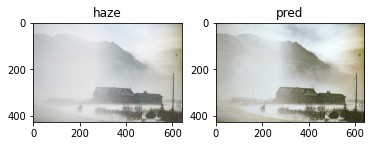

images.jpg


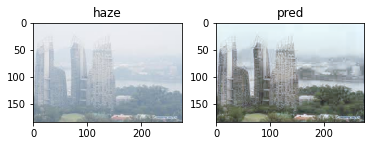

screenshot.jpg


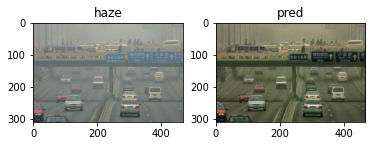

In [15]:
from tqdm.auto import tqdm
ssims = []
psnrs = []
times  = []
delta_e_array = []
for img in os.listdir(testing_path):
    print(img)
    start = time.time()
    haze = Image.open(testing_path+img).convert('RGB')
    if testing_mode == "with_gt":
        haze = tfs.Resize((240,240))(haze)
       
    haze1= tfs.Compose([
                        tfs.ToTensor(),
                        tfs.Normalize(mean=[0.64, 0.6, 0.58],std=[0.14,0.15, 0.152])])(haze)[None,::]
    haze_no=tfs.ToTensor()(haze)[None,::]
    with torch.no_grad():
        pred = net(haze1)
    ts=torch.squeeze(pred.clamp(0,1).cpu())
    tensorShow([haze_no,pred.clamp(0,1).cpu()],['haze','pred'])
    vutils.save_image(ts, output_path+img.split('.')[0]+'_FFA.jpg')
    torch.cuda.empty_cache()
    end = time.time()
    times.append(end-start)

In [16]:
print(f"{'No. '} {'time (s)':10s}")

for i, img in enumerate(os.listdir(testing_path)):
    print(f"{i:<4d} {times[i]:5f}")

No.  time (s)  
0    1.765997
1    0.551001
2    0.999999
